# Resturant Food Safety Inspection Prediction Using Natual Language Processing

references:
https://dev.socrata.com/foundry/data.cityofchicago.org/4ijn-s7e5

## Summary
1. [Objective](#objective)
2. [Understanding the Data](#data)\
    2.1 [Dataset Definitions](#dataset)\
    2.2 [Observations](#observations)\
    2.3 [Feature Engineering](#engineering)
4. [Model Building](#model)\
    4.1 [Model Overview](#modeloverview)
5. [Interpretation of Results](#interpretation)
6. [References](#references)



# 1. Objective
<a id='objective'></a>

The goal of this notebook is to build a multinomial classification model to predict the outcome of the food safety inspection reports based on the inspectors' comments. I will use from statistical analysis and natural language processing to accomplish this. I will also present the results of the classification model and suggest ways that it could be improved through further analysis.

Data provided by the City of Chicago via https://data.cityofchicago.org/ https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 as of early 2020

In [1]:
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import itertools
import os
import random
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import sys

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.mode.chained_assignment = None  # default='warn'


<a id='data'> </a>
# 2. Understanding the Data


<a id='dataset'> </a>
## 2.1 Preliminary Data Cleaning

In [2]:
#load the data
#df = pd.read_csv('../Food_Inspections.csv') #dataframe for modeling
#df_clean = df.copy() #cleaned dataframe for miscellaneous
#df_viz = df.copy() #dataframe for data viz exports for tableau


In [3]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
MyAppToken = 'KoNWmjvpkvV18BmVoGFCU1oCw'

client = Socrata("data.cityofchicago.org",
                  MyAppToken)
#                  userame="user@example.com",
 #                 password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("4ijn-s7e5", limit=250000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [4]:
results_df.shape

(212127, 22)

In [5]:
results_df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', ':@computed_region_awaf_s7ux',
       ':@computed_region_6mkv_f3dw', ':@computed_region_vrxf_vc4k',
       ':@computed_region_bdys_3d7i', ':@computed_region_43wa_7qmu'],
      dtype='object')

In [6]:
#drop extra columns from import
df = results_df.drop([':@computed_region_awaf_s7ux',
                 ':@computed_region_6mkv_f3dw',
                 ':@computed_region_vrxf_vc4k',
                 ':@computed_region_bdys_3d7i',
                 ':@computed_region_43wa_7qmu'], axis=1)

In [7]:
df.dtypes

inspection_id      object
dba_name           object
aka_name           object
license_           object
facility_type      object
risk               object
address            object
city               object
state              object
zip                object
inspection_date    object
inspection_type    object
results            object
violations         object
latitude           object
longitude          object
location           object
dtype: object

In [8]:
print(df.shape)
df.info()

(212127, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212127 entries, 0 to 212126
Data columns (total 17 columns):
inspection_id      212127 non-null object
dba_name           212127 non-null object
aka_name           209643 non-null object
license_           212110 non-null object
facility_type      207244 non-null object
risk               212055 non-null object
address            212126 non-null object
city               211972 non-null object
state              212079 non-null object
zip                212074 non-null object
inspection_date    212127 non-null object
inspection_type    212126 non-null object
results            212127 non-null object
violations         155705 non-null object
latitude           504 non-null object
longitude          504 non-null object
location           504 non-null object
dtypes: object(17)
memory usage: 27.5+ MB


In [9]:
df.isna().sum()

inspection_id           0
dba_name                0
aka_name             2484
license_               17
facility_type        4883
risk                   72
address                 1
city                  155
state                  48
zip                    53
inspection_date         0
inspection_type         1
results                 0
violations          56422
latitude           211623
longitude          211623
location           211623
dtype: int64

It appears that we have some incorrect data types and also some missing data. I'll inspect the data column by column

**inspection_id**

In [10]:
df['inspection_id'].isna().sum()

0

In [11]:
df['inspection_id'].sample(n=5)

28839     2268537
72852     1975370
52012     2102587
130508    1434677
21860     2300496
Name: inspection_id, dtype: object

**dba_name**

In [12]:
df['dba_name'].isna().sum()

0

In [13]:
df['dba_name'].sample(n=5)

135778                          MC DONALD'S
201184    BRIGHT HORIZONS CHICAGO WEST LOOP
166441                             EL NORTE
5388                               DSD DELI
80423                            SAMER FOOD
Name: dba_name, dtype: object

**aka_name**

In [14]:
df['aka_name'].isna().sum()

2484

In [15]:
#sample of the missing aka_name values
df[df['aka_name'].isna()][['inspection_id','dba_name','aka_name']]

,inspection_id,dba_name,aka_name
10,2453887,MICHACA ENTERPRISES CORPORATION,NaN
29,2453799,Bacolod Chicken House LLC,NaN
71,2453694,CENTERS FOR NEW HORIZONS,NaN
141,2453552,CLAMP DOWN BURGERS,NaN
335,2453268,CENTERS FOR NEW HORIZONS,NaN
...,...,...,...
212047,88206,elinas cafe,NaN
212074,78240,OBAMA FOOD MART,NaN
212084,78239,Yahs Cuisine,NaN
212104,158243,DUNKIN DONUTS,NaN


In [16]:
#fill NaN values with dba_name value
df['aka_name'] = df['aka_name'].fillna(df['dba_name'])

**license_**

In [17]:
df['license_'].isna().sum()

17

In [18]:
#Mostly churches...
df[df['license_'].isna()]['dba_name']

23551              ST. DEMETRIOS GREEK ORTHODOX CHURCH
40110              ST. DEMETRIOS GREEK ORTHODOX CHURCH
57061              ST. DEMETRIOS GREEK ORTHODOX CHURCH
82562              ST. DEMETRIOS GREEK ORTHODOX CHURCH
102541             ST. DEMETRIOS GREEK ORTHODOX CHURCH
127874             ST. DEMETRIOS GREEK ORTHODOX CHURCH
130434                                 ARGENTINA FOODS
145208             ST. DEMETRIOS GREEK ORTHODOX CHURCH
164873             ST. DEMETRIOS GREEK ORTHODOX CHURCH
168253                        OLD ST. PATRICK'S CHURCH
171610                 GOD'S BATTLE AXE PRAYER ACADEMY
171794                 GOD'S BATTLE AXE PRAYER ACADEMY
173335                 GOD'S BATTLE AXE PRAYER ACADEMY
182556             ST. DEMETRIOS GREEK ORTHODOX CHURCH
193740    AVALON COMMUNITY CHURCH/FREEDOM HOME ACADEMY
201903                             ST DEMETRIOS CHURCH
204528                        OLD ST. PATRICK'S CHURCH
Name: dba_name, dtype: object

In [19]:
#fill with "Not Disclosed"
df['license_'] = df['license_'].fillna('Not Disclosed')

**facility_type**

In [20]:
df['facility_type'].isna().sum()

4883

In [21]:
df[df['facility_type'].isna()]['dba_name'].value_counts().head(20)

SUBWAY                          34
DUNKIN DONUTS                   20
7-ELEVEN                        18
WHITE HEN PANTRY                18
HAROLD'S CHICKEN SHACK          15
TOKYO LUNCH BOXES & CATERING    13
KENTUCKY FRIED CHICKEN          12
MIDWEST BUDDHIST TEMPLE         11
MCDONALD'S                      10
MCDONALDS                        8
SCHLENKO INC.                    7
HEAVEN'S LEARNING GARDEN         7
GOLD COAST DOGS                  6
THUNDERBIRD CATERING             6
COLD STONE CREAMERY              6
BELEN                            5
CALIFORNIA FOODS                 5
QUIZNOS                          5
MAN-O-SALWA                      5
DEOLA'S                          5
Name: dba_name, dtype: int64

In [22]:
df[df['facility_type'].isna()]['dba_name'].value_counts().describe()

count    4111.000000
mean        1.187789
std         0.948943
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        34.000000
Name: dba_name, dtype: float64

In [23]:
df['facility_type'].value_counts().head(15)

Restaurant                         141142
Grocery Store                       27752
School                              13078
Children's Services Facility         3583
Bakery                               3097
Daycare (2 - 6 Years)                2794
Daycare Above and Under 2 Years      2581
Long Term Care                       1426
Catering                             1278
Liquor                                932
Mobile Food Dispenser                 883
Daycare Combo 1586                    741
Mobile Food Preparer                  673
Golden Diner                          599
Hospital                              592
Name: facility_type, dtype: int64

It's not clear why so many of these facility types are missing. Some of the businesses are obvious (7-Eleven, Quiznos, for instance) but many aren't... For now, I'll fill the NA values with not disclosed


In [24]:
df['facility_type'] = df['facility_type'].fillna('Not Disclosed')

**risk**

In [25]:
df['risk'].value_counts()

Risk 1 (High)      151632
Risk 2 (Medium)     41413
Risk 3 (Low)        18978
All                    32
Name: risk, dtype: int64

In [26]:
df['risk'].isna().sum()

72

In [27]:
df[df['risk'].isna()].sample(n=5, random_state=512)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
65121,2009375,"CHICAGO BEST DELI GROCERY,INC","CHICAGO BEST DELI GROCERY,INC",2512074,Not Disclosed,NaN,156-158 W 95TH ST,CHICAGO,IL,60628,2017-03-28T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN
181226,537572,unknown,unknown,0,Not Disclosed,NaN,10222 S wentworth AVE,CHICAGO,IL,60628,2011-09-07T00:00:00.000,Complaint-Fire,Business Not Located,NaN,NaN,NaN,NaN
35054,2229372,RICE THAI CAFE,RICE THAI CAFE,2589016,Not Disclosed,NaN,211`7 W FARRAGUT AVE,CHICAGO,IL,60625,2018-10-04T00:00:00.000,License,Business Not Located,NaN,NaN,NaN,NaN
196653,428391,BEST SUBS,BEST SUBS,0,Not Disclosed,NaN,2653 N WASTENAW AVE BLDG,CHICAGO,IL,60647,2010-10-29T00:00:00.000,Complaint,Business Not Located,NaN,NaN,NaN,NaN
25461,2286042,REIS AND IRVYS,REIS AND IRVYS,2659028,Not Disclosed,NaN,1801 W JACKSON BLVD,CHICAGO,IL,60612,2019-04-30T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN


In [97]:
df[(df.license_=='2048785')&(df.results=='Fail')].sample(n=3)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
20658,2303761,TRUMP INTERNATIONAL HOTEL,SIXTEEN,2048785,Restaurant,Risk 1 (High),401 N WABASH AVE,CHICAGO,IL,60611,2019-07-26T00:00:00.000,Suspected Food Poisoning,Fail,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: - MUST PROVIDE HANDWASH SIGNAGE AT ALL OF THE BARS' HANDWASH SINKS. - | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: - OBSERVED NO HANDWASH SINK IN THE OUTDOOR PATIO BAR AND IN THE OUTDOOR PATIO'S DISHWASH ROOM. MUST INSTALL A HANDWASH SINK IN BOTH AREAS. ALL HANDWASH SINKS SHALL BE EQUIPPED TO PROVIDE AN ADEQUATE SUPPLY OF WATER AT A TEMPERATURE OF AT LEAST 100F TO MEET FACILITY'S PEAK HOT WATER DEMANDS. PRIORITY FOUNDATION VIOLATION#:7-38-030(c). CITATION ISSUED. - | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: - OBSERVED A SLIGHT DEBRIS BUILDUP ON THE INTERIOR OF THE LEFT SIDE ICE MACHINE IN THE 16TH FL KITCHEN. MUST REMOVE DEBRIS, DETAIL CLEAN, SANITIZE, AND MAINTAIN. - | 39. CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY - Comments: - OBSERVED THE ICE BINS IN THE OUTDOOR PATIO BAR DO NOT HAVE ANY LIDS. MUST PROVIDE THE ICE BINS...",Not Disclosed,Not Disclosed,Not Disclosed,07/26/19
141499,1361138,TRUMP INTERNATIONAL HOTEL,SIXTEEN,2048785,Restaurant,Risk 1 (High),401 N WABASH AVE,CHICAGO,IL,60611,2013-09-20T00:00:00.000,Complaint,Fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPORTATION - Comments: FOOD NOT PROTECTED FROM CONTAMINATION DURING PREPARATON AND STORAGE. OBSERVED A VACUUM PACKAGING MACHINE ON THE PREMISES AND VACUUM PACKAGED FOODS (FISH, PASTA DOUGH, DUCK, BEANS, ETC.) STORED IN THE WALK-IN COOLERS AND WALK-IN FREEZER WITHOUT A CERTIFIED HACCP PROGRAM. ALSO OBSERVED CURING SALTS IN THE DRY STORAGE ROOM FOR CURING MEAT. MANAGEMENT INSTRUCTED THAT A CERTIFIED HACCP PROGRAM IS NEEDED FOR EACH PRODUCT THAT IS BEING CURED AND OR VACUUM PACKAGED. MANAGEMENT VOLUNTARILY DISCARDED APPROX. 185# OF FOOD WORTH APPROX. $1250. SERIOUS VIOLATION 7-38-005A. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: OBSERVED LIVE FRUIT FLIES ON THE WALLS AND CEILING OF THE BAR, 16TH FLOOR DISHWASHING AREA AND BEVERAGE SERVICE STATION. APPROXIMATELY 20 LIVE FRUIT FLIES WERE OBSERVED IN T...",Not Disclosed,Not Disclosed,Not Disclosed,09/20/13
182585,569519,TRUMP INTERNATIONAL HOTEL,SIXTEEN,2048785,Restaurant,Risk 1 (High),401 N WABASH AVE,CHICAGO,IL,60611,2011-08-09T00:00:00.000,Canvass,Fail,"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: (7-38-020) PEST ACTIVITY NOTED. FOUND 16-SMALL/FRUIT FLIES ON WALLS & CEILING ABOVE SMALL CABINETS OF A PREP TABLE AT THE WAIT STAFF AREA; 7-ON A CORNER WALL OF THE BAR (CLOSE TO THE LIQUOR ROOM DOOR); 8-ON THE CEILING/FRAMEWORK OF THE BAR COUNTER. INSTRUCTED TO ELIMINATE SOURCE & CLEAN/SANITIZE ALL AFFECTED AREAS. All necessary control measures shall be used to effectively minimize or eliminate the presence of rodents, roaches, and other vermin and insects on the premises of all food establishments, in food-transporting vehicles, and in vending machines. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: ROTTING, WATER-SOAKED WOODEN PANEL UNDER THE JUICE/DUMP SINK AREA (WAIT STAFF STATION) MUST BE REPLACED. ANY CUTTING BOARDS WITH DEEP/DARK GROOVES MUST BE REPLACED.All food and non-...",Not Disclosed,Not Disclosed,Not Disclosed,08/09/11


Notice that many of the missing risk values are records that were also missing other attributes...


In [31]:
#I'll fill missing risk values with not disclosed
df['risk'] = df['risk'].fillna('Not Disclosed')

**address**

In [32]:
df['address'].isna().sum()

1

In [33]:
df['address'].value_counts().head(10)

11601 W TOUHY AVE             2674
5700 S CICERO AVE              583
500 W MADISON ST               462
2300 S THROOP ST               405
324 N LEAVITT ST               391
131 N CLINTON ST               353
100 W RANDOLPH ST              331
222 W MERCHANDISE MART PLZ     279
600 E GRAND AVE                276
7601 S CICERO AVE              267
Name: address, dtype: int64

Some of these make sense:

* 5700 S CICERO AVE = Chicago Midway
* 500 W MADISON ST = Accenture Tower


**city**

In [34]:
df['city'].isna().sum()

155

In [35]:
df['city'].sample(n=5)

92451     CHICAGO
107274    CHICAGO
202716    CHICAGO
127048    CHICAGO
130129    CHICAGO
Name: city, dtype: object

In [36]:
df['city'] = df['city'].fillna('Not Disclosed')
df['city'] = df['city'].str.upper()

In [37]:
df['city'].value_counts().head(30)

CHICAGO              211702
NOT DISCLOSED           155
CCHICAGO                 48
SCHAUMBURG               27
MAYWOOD                  16
ELK GROVE VILLAGE        13
EVANSTON                 11
CHICAGOCHICAGO            9
CICERO                    9
SKOKIE                    8
INACTIVE                  8
ELMHURST                  7
NILES NILES               7
CALUMET CITY              6
CHCHICAGO                 6
WORTH                     5
OAK PARK                  5
SUMMIT                    4
BRIDGEVIEW                4
ALSIP                     4
CHARLES A HAYES           4
CHCICAGO                  3
SCHILLER PARK             3
312CHICAGO                3
EAST HAZEL CREST          3
CHICAGOI                  3
PLAINFIELD                3
ROSEMONT                  3
CHICAGOHICAGO             3
HIGHLAND PARK             2
Name: city, dtype: int64

In [38]:
df['city'] = df['city'].replace('chicago','CHICAGO')
df['city'] = df['city'].replace('Chicago','CHICAGO')
df['city'] = df['city'].replace('CCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGOCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGOHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGO.','CHICAGO')
df['city'] = df['city'].replace('312CHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHicago','CHICAGO')
df['city'] = df['city'].replace('CHICAGOI','CHICAGO')
df['city'] = df['city'].replace('CHCICAGO','CHICAGO')
#df['city'] = df['city'].replace('','CHICAGO')


**state**

In [39]:
df['state'].isna().sum()

48

In [40]:
df[df['state'].isna()][['dba_name','city','state']].head(10)

,dba_name,city,state
5755,CRATER FOOD & LIQUOR,CHICAGO,NaN
6237,YOLK - LINCOLN PARK,CHICAGO,NaN
6297,CRATER FOOD & LIQUOR,CHICAGO,NaN
6302,Starbucks Coffee#51211,NOT DISCLOSED,NaN
6782,STAX CAFE,CHICAGO,NaN
7200,WINGSTOP,CHICAGO,NaN
19278,"AMY BECK CAKE DESIGN, LLC",NOT DISCLOSED,NaN
23320,STAX CAFE,CHICAGO,NaN
23758,CITY HALL. LLC,CHICAGO,NaN
23765,CITY HALL. LLC,CHICAGO,NaN


It appears there is a data input problem. For now, I'll manually fill missing states


In [41]:
df.loc[(df.city=='CHICAGO')&(df.state.isna()),'state'] = 'IL'

In [42]:
df['state'] = df['state'].fillna('Not Disclosed')

In [43]:
df['state'].value_counts()

IL               212104
Not Disclosed        20
IN                    1
NY                    1
WI                    1
Name: state, dtype: int64

Not sure why there are other states in this dataset. For now, I'll drop other states.

In [44]:
index_list = df[df.state != 'IL'].index.to_list()

df = df.drop(index_list)

**zip**

In [45]:
df['zip'].isna().sum()

53

There are only 52 observations with missing zip values so I'll drop these values


In [46]:
df = df.dropna(subset=['zip'])

**inspection_date**

In [47]:
df['inspection_date'].isna().sum()

0

In [48]:
print(df['inspection_date'][5])
type(df['inspection_date'].iloc[5])

2020-10-28T00:00:00.000


str

I'll need to conver the inspection date column to datetime

In [49]:
#Convert inspection_date column
df['inspection_date_new'] = df['inspection_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))


In [50]:
df.iloc[0]['inspection_date_new'].strftime(format='%x')

'10/28/20'

In [51]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])


2020-10-28 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

In [52]:
df['inspection_date_new'] = df['inspection_date_new'].apply(lambda x: x.strftime(format='%x'))

In [53]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])

10/28/20


str

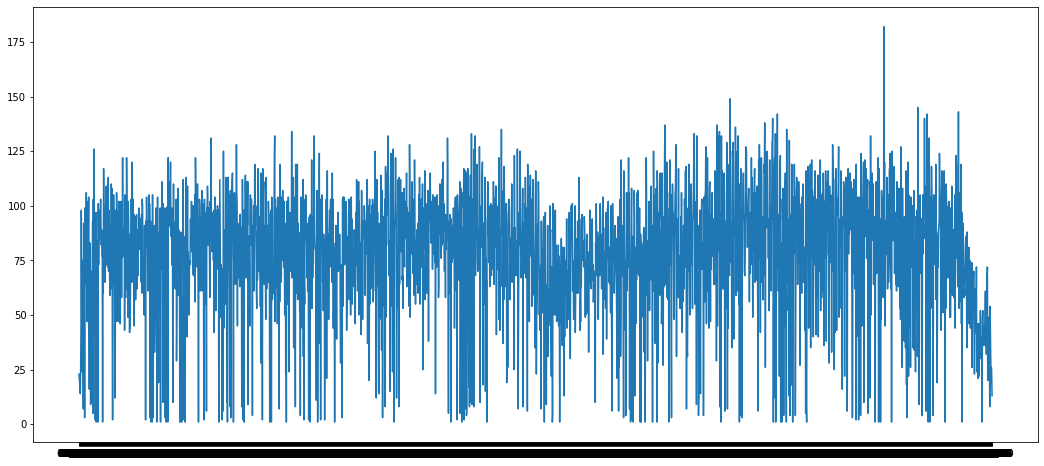

In [54]:
import matplotlib.pylab as plt
from collections import Counter

# Tally occurrences of words in a list
cnt = Counter()
for day in df['inspection_date_new']:
    cnt[day] += 1


lists = sorted(cnt.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(18,8))
plt.plot(x, y)

plt.show()


**inspection_type**


In [55]:
df['inspection_type'].isna().sum()


1

In [56]:
df = df.dropna(subset=['inspection_type'])


In [57]:
df['inspection_type'].value_counts().head(15)


Canvass                                   112789
License                                    27823
Canvass Re-Inspection                      22542
Complaint                                  19661
License Re-Inspection                       9480
Complaint Re-Inspection                     8098
Short Form Complaint                        7137
Suspected Food Poisoning                     874
Consultation                                 672
License-Task Force                           604
Tag Removal                                  603
Recent Inspection                            357
Out of Business                              284
Task Force Liquor 1475                       252
Suspected Food Poisoning Re-inspection       193
Name: inspection_type, dtype: int64

**results**


In [58]:
pd.DataFrame({'counts':df['results'].value_counts(),
              'percentage':df['results'].value_counts()/df.shape[0]})

,counts,percentage
Pass,111305,0.524900
Fail,40988,0.193294
Pass w/ Conditions,32027,0.151035
Out of Business,18390,0.086725
No Entry,7066,0.033322
Not Ready,2204,0.010394
Business Not Located,70,0.000330


I'm building a classification model to predict the multinomial classifications above based on the inspector's comments. Therefore, I plan to exclude the four results that we do not have sufficient records. Separately, I also noticed some records for "no entry" still had comments associated with them. 

In [59]:
df[df['results']=='No Entry']

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
54,2453751,EL POTRILLO,EL POTRILLO,13419,Liquor,Risk 3 (Low),5129 S ARCHER AVE,CHICAGO,IL,60632,2020-10-23T00:00:00.000,Complaint Re-Inspection,No Entry,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(O): NO EMPLOYEE HEALTH POLICY ON SITE. INSTD TO PROVIDE A VERFIABLE EMPLOYEE HEALTH POLICY AND MAINTAIN. PRIORITY FOUNDATION 7-38-010 | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11: NO PROCEDURE IN PLACE FOR VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: 5-204.11: NO HANDWASH SINK IN BAR AREA. INSTD TO PROVIDE A HANDWASH SINK PROPERLY CONNECTED UNDER CITY PRESSURE WITH 100F-120F TEMPERATURE OF WATER. PRIORITY FOUNDATION 7-38-030(C) | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: 6-501.111: 3 LIVE ROACHES AND ROACH FECES NOTED AT BAR 3-COMPARTMENT SINK. INSTD TO REMOVE ROACHES AND FECES, CLEAN AND SANITIZED AFFECTED AREAS. CITATION ISSUED PRIORITY FO...",NaN,NaN,NaN,10/23/20
82,2453819,LOS MIXIOTES,LOS MIXIOTES,2433002,Restaurant,Risk 1 (High),6530-6532 S PULASKI RD,CHICAGO,IL,60629,2020-10-22T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,10/22/20
99,2453716,GOURMET GORILLA,HUNTER PERKINS CAMPUS,2608552,CHARTER SCHOOL,Risk 1 (High),1700 W 83RD ST,CHICAGO,IL,60620,2020-10-22T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,10/22/20
104,2453650,STUDIO MOVIE GRILL,STUDIO MOVIE GRILL,2309244,Restaurant,Risk 1 (High),210 W 87TH ST,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: Violation Codes: 6-501.11 Inspector Comments: DAMAGED FLOOR TILE AROUND THE FLOOR DRAIN BEHIND THE CONCESSION STAND. INSTRUCTED TO REPAIR/REPLACE FLOOR TILE. MAINTAIN SMOOTH AND EASILY CLEANABLE FLOORS. | 58. ALLERGEN TRAINING AS REQUIRED - Comments: Violation Codes: 2-102.13 Inspector Comments: OBSERVED NO ALLERGEN TRAINING AVAILABLE DURING INSPECTION. ALL CERTIFIED MANAGERS MUST PROVIDE ALLERGEN TRAINING.",NaN,NaN,NaN,10/21/20
113,2453659,WALMART #5781,WALMART #5781,2104019,Grocery Store,Risk 1 (High),8331 S STEWART AVE,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: Violation Codes: 4-602.13 Inspector Comments: FOUND BLACK MOLD LIKE SUBSTANCE ON THE STORAGE RACKS WHERE THE JUICES ARE STORED IN THE REAR COLD HOLDING UNIT. INSTRUCTED TO KEEP RACKS CLEAN.,NaN,NaN,NaN,10/21/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167503,1230048,TAPAS LAS RAMBLAS,TAPAS LAS RAMBLAS,1799141,Restaurant,Risk 1 (High),5101-5103 N CLARK ST,CHICAGO,IL,60640,2012-06-05T00:00:00.000,Complaint,No Entry,NaN,NaN,NaN,NaN,06/05/12
167852,1229215,CHICAGO FONDUE STUBE,CHICAGO FONDUE STUBE,26813,Restaurant,Risk 1 (High),2717 W PETERSON AVE,CHICAGO,IL,60659,2012-05-29T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,05/29/12
167892,1229216,KATSU ENTERPRISESES INC,KATSU JAPANESE RESTAURANT,16281,Restaurant,Risk 1 (High),2651 W PETERSON AVE,CHICAGO,IL,60659,2012-05-29T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,05/29/12
172479,671042,MAGNOLIA CAFE,MAGNOLIA CAFE,1968899,Restaurant,Risk 1 (High),1224 W WILSON AVE,CHICAGO,IL,60640,2012-03-01T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,03/01/12


In [60]:
#I'm setting the threshold for data sufficiency at 15%, so if a result is not at least 15% of the dataset, it will be dropped
perc = df['results'].value_counts()/df.shape[0]
my_list = perc[perc>0.15].keys().to_list()
print(my_list)

df = df[df.results.isin(my_list)]

['Pass', 'Fail', 'Pass w/ Conditions']


**violations**


In [61]:
df.violations.isna().sum()

29240

In [62]:
df[df['violations'].isna()].sample(n=10, random_state=512)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
49354,2117177,"WENDY'S PROPERTIES, LLC",WENDY'S,2405952,Restaurant,Risk 1 (High),8302 S ASHLAND AVE,CHICAGO,IL,60620,2017-12-13T00:00:00.000,Complaint,Pass,NaN,NaN,NaN,NaN,12/13/17
182935,598311,BONY'S FOOD MART,BONY'S FOOD MART,2107933,Grocery Store,Risk 3 (Low),1942 S CARPENTER ST,CHICAGO,IL,60608,2011-08-03T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN,NaN,08/03/11
204388,231408,CORK AND KERRY ON 33RD,CORK AND KERRY,2013349,Restaurant,Risk 1 (High),3258 S PRINCETON AVE,CHICAGO,IL,60616,2010-06-10T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN,NaN,06/10/10
103630,1387862,SHARKS FISH & CHICKEN,SHARKS FISH & CHICKEN,1477112,Restaurant,Risk 2 (Medium),2027 E 95TH ST,CHICAGO,IL,60617,2015-07-13T00:00:00.000,Short Form Complaint,Pass,NaN,NaN,NaN,NaN,07/13/15
132766,1401626,"POTBELLY SANDWICH WORKS, LLC","POTBELLY SANDWICH WORKS, LLC",2313501,Restaurant,Risk 1 (High),1293 N MILWAUKEE AVE,CHICAGO,IL,60622,2014-02-28T00:00:00.000,License,Fail,NaN,NaN,NaN,NaN,02/28/14
137667,1375518,Michigan Candy Store,Michigan Candy Store,2004511,Grocery Store,Risk 3 (Low),980 N MICHIGAN AVE,CHICAGO,IL,60611,2013-11-18T00:00:00.000,Canvass,Pass,NaN,NaN,NaN,NaN,11/18/13
138046,1375335,HEARTLAND CAFE,HEARTLAND CAFE,2177844,Restaurant,Risk 1 (High),7000 N GLENWOOD AVE,CHICAGO,IL,60626,2013-11-12T00:00:00.000,License,Fail,NaN,NaN,NaN,NaN,11/12/13
177948,555307,LONGWOOD FOODS,LONGWOOD FOODS,1143139,Grocery Store,Risk 2 (Medium),11106 S LONGWOOD DR,CHICAGO,IL,60643,2011-11-04T00:00:00.000,Canvass Re-Inspection,Pass,NaN,NaN,NaN,NaN,11/04/11
207566,150325,D'ABSOLUTE RESTAURANT & CATERING,D'ABSOLUTE RESTAURANT & CATERING,1443178,Catering,Risk 1 (High),5106 W IRVING PARK RD,CHICAGO,IL,60641,2010-04-08T00:00:00.000,No Entry,Pass,NaN,NaN,NaN,NaN,04/08/10
130433,1434697,VAINILLA BEAN BAKE SHOP INC,VAINILLA BEAN BAKE SHOP INC,2314013,Bakery,Risk 2 (Medium),2627 W DIVISION ST,CHICAGO,IL,60622,2014-04-10T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN,NaN,04/10/14


The inspector's comments are a key independent variable. Therefore, any records with missing comments have to be dropped

In [63]:
df = df.dropna(subset=['violations'])

**latitude & longitude, and location**

In [64]:
print('lat:',df.latitude.isna().sum())
print('long:',df.longitude.isna().sum())
print('location:',df['location'].isna().sum())

lat: 154795
long: 154795
location: 154795


In [65]:
df['latitude'] = df['latitude'].fillna('Not Disclosed')
df['longitude'] = df['longitude'].fillna('Not Disclosed')
df['location'] = df['location'].fillna('Not Disclosed')


I want to use the address and the geopy package to pull the latitude and longitude values. But I noticed there were a lot of typos in the City list. We know that a city can have multiple zipcodes but a zipcode can only have one city.

## sample geopy code

In [67]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="sample_code")
location = geolocator.geocode("121 N LaSalle St, Chicago, IL 60602")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)


121, North LaSalle Street, Loop, Chicago, Cook County, Illinois, 60602, United States of America
(41.88341706625744, -87.632303164487)
{'place_id': 248024928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 435704691, 'boundingbox': ['41.883367066257', '41.883467066257', '-87.632353164487', '-87.632253164487'], 'lat': '41.88341706625744', 'lon': '-87.632303164487', 'display_name': '121, North LaSalle Street, Loop, Chicago, Cook County, Illinois, 60602, United States of America', 'class': 'place', 'type': 'house', 'importance': 0.731}


Shape of the dataset

In [68]:
df.shape

(155080, 18)

# Data Dictionary

**Inspection ID:** unqiue identifier

**DBA Name:** "doing businessness as"

**AKA Name:** "also known as"

**License #:** License Number identification

**Facility Type:** The type of facility. Examples include: restaurant, grocery store, school, bakery, catering, etc.

**Risk:** Risk category. Categorical value of risk 1, risk 2, risk 3, or "all".

**Address:** Number and street name. For example, 401 N WABASH AVE

**City:** Self explanatory

**State:** Self explanatory

**Zip:** Self explanatory

**Inspection Date:**

**Inspection Type:** 

**Results:** Categorical value: Pass, Fail, Pass w/ Conditions, Out of Business, No Entry, Not Ready, Business Not Located

**Violations:** String of specific code violation and inspector's comments.

**Latitude:** Self explanatory

**Longitude:** Self explanatory

**Location:** Comination of latitude and longitude columns

<a id='observations'></a>
### 2.1 Observations

Two analyses: descriptive analysis and predictive modeling. For the predictive modeling, we only care about the 'results' and 'violations' columns



In [69]:
#Ten most popular facility types
df['facility_type'].value_counts()[:15]

Restaurant                         106122
Grocery Store                       19984
School                              11413
Children's Services Facility         2708
Bakery                               2328
Daycare Above and Under 2 Years      1985
Daycare (2 - 6 Years)                1938
Long Term Care                       1217
Catering                              856
Liquor                                513
Daycare Combo 1586                    491
Golden Diner                          455
Mobile Food Preparer                  412
Hospital                              404
Wholesale                             315
Name: facility_type, dtype: int64

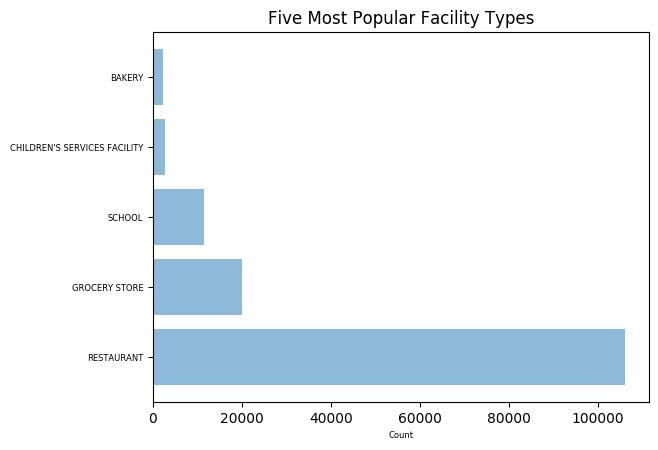

In [70]:
vc = df['facility_type'].str.upper().value_counts()[:5]


import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontsize=6)
plt.xlabel('Count', fontsize=6)
plt.title('Five Most Popular Facility Types')

plt.show()

In [71]:
df['risk'].value_counts()

Risk 1 (High)      116788
Risk 2 (Medium)     29252
Risk 3 (Low)         9038
Not Disclosed           2
Name: risk, dtype: int64

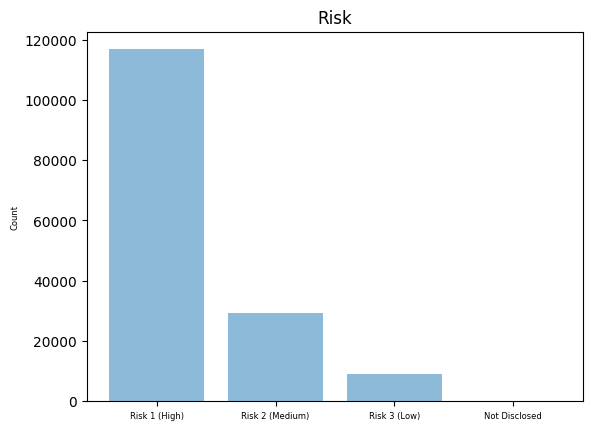

In [72]:
vc = df['risk'].value_counts()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Risk')

plt.show()

In [73]:
#sample restaurant
df[df['facility_type']=='Restaurant'].sample(n=1, random_state=777)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
27932,2279496,BITES ASIAN TAPAS & SUSHI,BITES ASIAN TAPAS & SUSHI,1883543,Restaurant,Risk 1 (High),3313 N CLARK ST,CHICAGO,IL,60657,2019-03-15T00:00:00.000,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: NOTED NO EMPLOYEE HEALTH POLICY ON SITE AT THE TIME OF INSPECTION FOLLOWING THE NEW CODE AND GUIDELINES. INSTRUCTED TO HAVE VERIFICATION OF POLICY FOR EACH EMPLOYEE ONE ON SITE AT ALL TIMES. PRIORITY FOUNDATION #7-38-010. NO CITATION ISSUED TODAY | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: MANAGEMENT UNABLE TO PROVIDE A PROCEDURE FOR CLEANING UP VOMITING AND DIARRHEA.INSTRUCTED TO HAVE ONE INCLUDING THE CHEMICALS AND SUPPLIES NEEDED. PRIORITY FOUNDATION VIOLATION #7-38-005. NO CITATION ISSUED - | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: NOTED NO HAND WASH SINK THE DISH WASHING AREA AT THE BASEMENT PREP AREA. ADDITIONAL HAND WASH SINK NEEDED. PRIORITY FOUNDATION VIOLATION #7-38-030(C). NO CITATION ISSUED TODAY | 23. PROPER DATE MARKING AND DISPOSITION - Comments: NOTED TEMPERATURE CONTROLLED FOR SAFETY FOOD ...",Not Disclosed,Not Disclosed,Not Disclosed,03/15/19


Cities

In [74]:
df['city'].value_counts()[:10]

CHICAGO              154952
NOT DISCLOSED            50
SCHAUMBURG               15
ELK GROVE VILLAGE         8
EVANSTON                  7
ELMHURST                  4
SKOKIE                    4
NILES NILES               4
MAYWOOD                   4
PLAINFIELD                3
Name: city, dtype: int64

In [75]:
len(df['city'].unique())

29

Results

In [76]:
df['results'].value_counts()

Pass                  85790
Fail                  37821
Pass w/ Conditions    31469
Name: results, dtype: int64

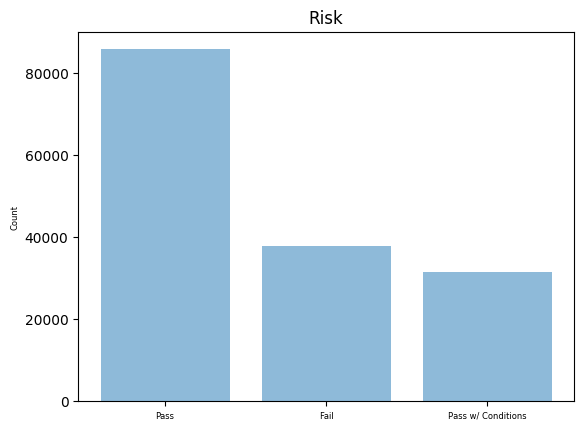

In [77]:
vc = df['results'].value_counts()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Risk')

plt.show()

In [78]:
df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', 'inspection_date_new'],
      dtype='object')

In [105]:
#Drop Unneccesary Columns
select_cols = ['results', 'violations']

#Create prediction dataframe for the prediction modeling
pred_df = df.copy()
pred_df = pred_df[select_cols]


In [106]:
pred_df.head(2)

,results,violations
1,Fail,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: NOTED NO SOAP AT EMPLOYEE BATHROOM HAND WASH SINK. INSTRUCTED TO HAVE SOAP AND PAPER TOWELS AT ALL HAND WASH SINKS AT ALL TIMES.PRIORITY FOUNDATION VIOLATION #7-38-030(C) | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: NO PAPER TOWELS AT EMPLOYEE BATHROOM HAND WASH SINK. INSTRUCTED TO HAVE SOAP AND PAPER TOWELS AT ALL HAND WASH SINKS.PRIORITY FOUNDATION #7-38-030(C) CONSOLIDATED WITH ABOVE CITATION. | 52. SEWAGE & WASTE WATER PROPERLY DISPOSED - Comments: NOTED WASTE WATER THROUGHOUT FLOOR FROM THE FLOOR DRAINS WHEN WATER IS RELEASED FROM THE REAR HAND WASH SINK AND 3 COMPARTMENT SINK AND THE FRONT HAND WASH SINK WITH STRONG OFFENSIVE ODOR. INSTRUCTED TO REPAIR AND MAINTAIN. PRIORITY VIOLATION #7-38-030 (C). | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: INSTRUCTED TO DETAIL CLEAN, SANITIZE AND MAINTAIN ALL FLOORS, ALONG WALL BASE AND UNDERNEATH EQUIPMENT ..."
3,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: OBSERVED NO COVERED WASTE RECEPTACLE IN WASHROOM. INSTRUCTED MANAGER TO PROVIDE.ALL WASHROOMS USED BY FEMALES MUST HAVE A COVERED RECEPTACLE FOR SANITARY NAPKINS."


In [107]:
print(pred_df.info())
print(pred_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155080 entries, 1 to 212125
Data columns (total 2 columns):
results       155080 non-null object
violations    155080 non-null object
dtypes: object(2)
memory usage: 3.5+ MB
None
       results  \
count   155080   
unique       3   
top       Pass   
freq     85790   

                                                                                                                               violations  
count                                                                                                                              155080  
unique                                                                                                                             153985  
top     45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING. MUST PROVIDE.  
freq                                                                                                                    

Location

<a id='engineering'></a>
## 2. Feature Engineering

Notice, the format of the violations column. The column includes the code violation number, the code description, and the inspector's comments on the specific violation. 

Sample:

"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: POOLING WATER THROUGHOUT REAR LARGE BAR. MUST MAINTAIN DRY. MISSING FLOOR TILES AND UNEVEN FLOORING THROUGHOUT DISH AREA WITH POOLING WATER. MUST MAKE FLOORS SMOOTH AND EASILY CLEANABLE.   | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: MUST INSTALL CEILINGS IN THE NEWLY INSTALL FRONT WASHROOMS. RAW WOODEN WALL COVERING IN MENS WASHROOM. MUST PROPERLY SEAL."


* Extract only comments from violations, drop rest of text


* map Results_Flag
The results currently fall into one of three buckets. I want to map these categorical columns to specific flag values.

In [108]:
#Check sample Violation entry
pred_df['violations'].sample(n=1, random_state=512)

73378    16. FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPORTATION - Comments: OBSERVED  ICE MACHINE LOCATED BEHIND THE FRONT COUNTER, WITH A PINK SLIME LIKE SUBSTANCE ACCUMULATING ON THE INTERIOR PANEL, LIKELY TO CONTAMINATE THE ICE. INSTRUCTED TO DISCARD ICE. DISCONTINUE USE OF MACHINE UNTIL  DETAIL CLEANED AND SANITIZED. SERIOUS VIOLATION 7-38-005(A)  | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED INTERIOR OF MICROWAVES BEHIND FRONT COUNTER AND IN THE REAR PREP NOT CLEAN. INTERIOR SURFACES OF 2-DOOR REACH IN COOLERS AND A FREEZER IN REAR. ALSO PREP TABLE IN REAR NOT CLEAN. INSTRUCTED TO DETAIL CLEAN ALL ND MAINTAIN. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: OBSERVED FLOORS NOT CLEAN IN THE FOLLOWING AREAS; FRONT AND REAR PREP AREAS. INSTRUCTED TO DETAIL CLEAN AND MAINTAIN. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS 

In [109]:
#regex expression to extract the text following "Comments:"
pred_df.violations = pred_df.violations.str.findall(r"(?:\sComments:\s.*?)?(?:[|]|$)")

In [110]:
#Now check the same sample
pred_df['violations'].sample(n=1, random_state=512)

73378    [ Comments: OBSERVED  ICE MACHINE LOCATED BEHIND THE FRONT COUNTER, WITH A PINK SLIME LIKE SUBSTANCE ACCUMULATING ON THE INTERIOR PANEL, LIKELY TO CONTAMINATE THE ICE. INSTRUCTED TO DISCARD ICE. DISCONTINUE USE OF MACHINE UNTIL  DETAIL CLEANED AND SANITIZED. SERIOUS VIOLATION 7-38-005(A)  |,  Comments: OBSERVED INTERIOR OF MICROWAVES BEHIND FRONT COUNTER AND IN THE REAR PREP NOT CLEAN. INTERIOR SURFACES OF 2-DOOR REACH IN COOLERS AND A FREEZER IN REAR. ALSO PREP TABLE IN REAR NOT CLEAN. INSTRUCTED TO DETAIL CLEAN ALL ND MAINTAIN. |,  Comments: OBSERVED FLOORS NOT CLEAN IN THE FOLLOWING AREAS; FRONT AND REAR PREP AREAS. INSTRUCTED TO DETAIL CLEAN AND MAINTAIN. |,  Comments: OBSERVED EXTRA LARGE POTS STORED IN THE REAR PREP AREA.  THEY WERE NOT BEING USED AT THE TIME OF THE INSPECTION, BUT IF USED TO COOK FOOD, THEY ARE TOO LARGE TO PROPERLY CLEAN AND SANITIZE IN THE 3-COMP SINKS ON THE PREMISES., ]
Name: violations, dtype: object

In [113]:
df['violations'].str.join(' ')

1         1 0 .   A D E Q U A T E   H A N D W A S H I N G   S I N K S   P R O P E R L Y   S U P P L I E D   A N D   A C C E S S I B L E   -   C o m m e n t s :   N O T E D   N O   S O A P   A T   E M P L O Y E E   B A T H R O O M   H A N D   W A S H   S I N K .   I N S T R U C T E D   T O   H A V E   S O A P   A N D   P A P E R   T O W E L S   A T   A L L   H A N D   W A S H   S I N K S   A T   A L L   T I M E S . P R I O R I T Y   F O U N D A T I O N   V I O L A T I O N   # 7 - 3 8 - 0 3 0 ( C )   |   1 0 .   A D E Q U A T E   H A N D W A S H I N G   S I N K S   P R O P E R L Y   S U P P L I E D   A N D   A C C E S S I B L E   -   C o m m e n t s :   N O   P A P E R   T O W E L S   A T   E M P L O Y E E   B A T H R O O M   H A N D   W A S H   S I N K .   I N S T R U C T E D   T O   H A V E   S O A P   A N D   P A P E R   T O W E L S   A T   A L L   H A N D   W A S H   S I N K S . P R I O R I T Y   F O U N D A T I O N   # 7 - 3 8 - 0 3 0 ( C )   C O N S O L I D A T E D   W I T H   A B 

Notice, each observation is now a list of the inspector's comments. 

In [ ]:
#df['col'].apply(', '.join)

In [91]:
pred_df.violations = pred_df.violations.apply(lambda x: str.join(' ')

AttributeError: Can only use .str accessor with string values!

In [85]:
#Lemmatize Violations
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#remove "Comments"
pred_df['violations'] = pred_df['violations'].str.replace('Comments*\s','')
pred_df['violations'] = pred_df['violations'].str.replace('Comments','')

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

pred_df.violations = pred_df.violations.apply(lambda x: lemmatize_text(x))

pred_df.violations = pred_df.violations.str.join(' ')



#Remove Punctuation
pred_df['violations'] = pred_df['violations'].str.replace('[^\w\s]','')

#Remove non-alphanumeric
pred_df['violations'] = pred_df['violations'].str.replace('[^\D\s]','')


TypeError: expected string or bytes-like object

In [88]:
type(pred_df['violations'])

pandas.core.series.Series

In [89]:
pred_df.iloc[0]['violations']

[' Comments: NOTED NO SOAP AT EMPLOYEE BATHROOM HAND WASH SINK. INSTRUCTED TO HAVE SOAP AND PAPER TOWELS AT ALL HAND WASH SINKS AT ALL TIMES.PRIORITY FOUNDATION VIOLATION #7-38-030(C) |',
 ' Comments: NO PAPER TOWELS AT EMPLOYEE BATHROOM HAND WASH SINK. INSTRUCTED TO HAVE SOAP AND PAPER TOWELS AT ALL HAND WASH SINKS.PRIORITY FOUNDATION #7-38-030(C) CONSOLIDATED WITH ABOVE CITATION. |',
 ' Comments: NOTED WASTE WATER THROUGHOUT FLOOR FROM THE FLOOR DRAINS WHEN WATER IS RELEASED FROM THE REAR HAND WASH SINK AND 3 COMPARTMENT SINK AND THE FRONT HAND WASH SINK WITH STRONG OFFENSIVE ODOR. INSTRUCTED TO REPAIR AND MAINTAIN. PRIORITY VIOLATION #7-38-030 (C). |',
 ' Comments: INSTRUCTED TO DETAIL CLEAN, SANITIZE AND MAINTAIN ALL FLOORS, ALONG WALL BASE AND UNDERNEATH EQUIPMENT ESPECIALLY WITH THE WASTE WATER AND FOOD DEBRIS/LITTER.',
 '']

In [ ]:
#Now check sample violation
pred_df['violations'].sample(n=1, random_state=512)

Now, we need to conver the results column into a categorical flag

In [ ]:
pred_df['results'].value_counts()

In [ ]:
# convert label to a binary numerical variable
pred_df['results_flag'] = pred_df.results.map({'Pass':0,
                                     'Fail':1,
                                     'Pass w/ Conditions':2,
                                     'No Entry':3,
                                     'Not Ready':4,
                                     'Out of Business':5 })

In [ ]:
pred_df.sample(n=5, random_state=312)

In [ ]:
print('number of unique addresses in dataset: ',len(df.address.unique()))
print('number of inspections: ', len(df.inspection_id.unique()))
print('shape of dataset: ', df.shape)
print('first inspection date: ', df.inspection_date.min())
print('most recent inspection date: ', df.inspection_date.max())

In [ ]:
print('damaged: ', lemmatize_text('damaged'))
print('bats: ', lemmatize_text('bats'))
print('feet: ', lemmatize_text('feet'))

In [ ]:
df['violations'].sample(n=1)

# Export Dataset

In [148]:
from datetime import date

today = date.today()
df.to_csv('../dataset_exports/'+str(today)+'_data.csv')


<a id='model'></a>
# 3. Model

<a id='modeloverview'> </a>
## 3.1 Model Overview


### 3.1 Set X & y Variables

In [165]:
X = pred_df.violations
y = pred_df.results_flag
print(X.shape)
print(y.shape)

(155001,)
(155001,)


### 3.2 Train/Test Split

In [96]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(124000,)
(31001,)
(124000,)
(31001,)


### 3.3 Vectorize The Text

In [97]:
# instantiate the vectorizer
vect = CountVectorizer()

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<124000x90729 sparse matrix of type '<class 'numpy.int64'>'
	with 8392952 stored elements in Compressed Sparse Row format>

In [98]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<31001x90729 sparse matrix of type '<class 'numpy.int64'>'
	with 2079383 stored elements in Compressed Sparse Row format>

In [99]:
countvectorizer_matrix = vect.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

,___lbs,__through,_a,aa,aab,aaccumuation,aade,aafound,aair,aal,...,zucchini,zucchinibaby,zucchinin,zuccini,zuchinicabbagecooked,zumba,zumex,zurich,ºc,ºf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='model'> </a>
## 5. Build Baseline Models
* "Model 1", Naive Bayes Model
* "Model 2", Logistic Regression
* "Model 3", Support Vector Machine 

## a) Naive Bayes Model

\# instantiate a Multinomial Naive Bayes model\
nb = MultinomialNB()

\# train and time the model using X_train_dtm\
%time nb.fit(X_train_dtm, y_train)

\# make class predictions for X_test_dtm\
y_pred_class = nb.predict(X_test_dtm)

\# calculate accuracy of class predictions\
print(metrics.accuracy_score(y_test, y_pred_class))

\# calculate precision and recall\
print(classification_report(y_test, y_pred_class))

\#Check for over fitting\
y_pred_class_train = nb.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

\# calculate the confusion matrix\
print(metrics.confusion_matrix(y_test, y_pred_class))

## b) Logistic Regression

\# instantiate a logistic regression model\
logreg = LogisticRegression(max_iter=10000)

\# train the model using X_train_dtm\
%time logreg.fit(X_train_dtm, y_train)

\# make class predictions for X_test_dtm\
y_pred_class = logreg.predict(X_test_dtm)

\# calculate accuracy of class predictions\
print(metrics.accuracy_score(y_test, y_pred_class))

\# calculate precision and recall\
print(classification_report(y_test, y_pred_class))

\#Check for over fitting\
y_pred_class_train = logreg.predict(X_train_dtm)

print(classification_report(y_train, y_pred_class_train))

\# calculate the confusion matrix\
print(metrics.confusion_matrix(y_test, y_pred_class))

## c) Support Vector Machine

\# instantiate a SVM model\
svm = SGDClassifier(max_iter=100, tol=None)

\# train the model using X_train_dtm\
%time svm.fit(X_train_dtm, y_train)

\# make class predictions for X_test_dtm\
y_pred_class = svm.predict(X_test_dtm)

\# calculate accuracy of class predictions\
print(metrics.accuracy_score(y_test, y_pred_class))

\# calculate precision and recall\
print(classification_report(y_test, y_pred_class))

\#Check for over fitting\
y_pred_class_train = svm.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

\# calculate the confusion matrix\
print(metrics.confusion_matrix(y_test, y_pred_class))

# All Three Models In One Code Chunk

In [166]:
# instantiate the vectorizer
vect = CountVectorizer()

# equivalently: combine fit and transform into a single step
#X_train_dtm = vect.fit_transform(X_train)
X_dtm = vect.fit_transform(X)

# examine the document-term matrix
X_dtm

<155001x102274 sparse matrix of type '<class 'numpy.int64'>'
	with 10446989 stored elements in Compressed Sparse Row format>

In [167]:
countvectorizer_matrix = vect.fit_transform(X)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

,___lbs,__through,_a,aa,aab,aaccumuation,aade,aafound,aair,aal,...,zucchinin,zucchinisliced,zuccini,zuchinicabbagecooked,zuchinisasparagus,zumba,zumex,zurich,ºc,ºf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
from sklearn import model_selection

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('NB', MultinomialNB()))
models.append(('LR', LogisticRegression(max_iter=10000)))
models.append(('SVM', SGDClassifier(max_iter=100, tol=None)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
	cv_results = model_selection.cross_val_score(model, X_dtm, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


NB: 0.823556 (0.002072)
LR: 0.923471 (0.001844)
SVM: 0.913872 (0.002317)


from sklearn import model_selection

# prepare configuration for cross validation test harness
#seed = 7
# prepare models
models = []
models.append(('NB', MultinomialNB()))
models.append(('LR', LogisticRegression(max_iter=10000)))
models.append(('SVM', SGDClassifier(max_iter=100, tol=None)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	cv_results = model_selection.cross_val_score(model, X_train_dtm, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


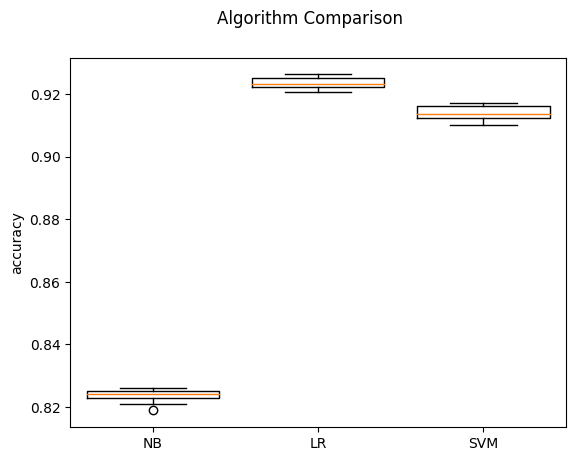

In [170]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, widths=.8)
ax.set_xticklabels(names)
ax.set_ylabel('accuracy')
plt.show()

In [173]:
pred_df.results.value_counts()

Pass                  85754
Fail                  37804
Pass w/ Conditions    31443
Name: results, dtype: int64

In [177]:
pd.DataFrame({'results':pred_df.results.value_counts(), 'percentage':round(pred_df.results.value_counts()/len(pred_df),2)})

,results,percentage
Pass,85754,0.55
Fail,37804,0.24
Pass w/ Conditions,31443,0.20


# 6. Improve Model Performance (for best performing model)
* Remove stopwords
* Include n-grams
* Limit min & max document frequencies

In [227]:
#default parameters for countvectorizer model
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [228]:
# remove English stop words
vect_optimized = CountVectorizer(stop_words='english',
                                 lowercase=True,
                                 ngram_range=(1,3))


In [ ]:
countvectorizer_matrix = vect_optimized.fit_transform(X)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect_optimized.get_feature_names())
countvectorizer_matrix_df

In [ ]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect_optimized.fit_transform(X_train)
X_test_dtm = vect_optimized.transform(X_test)

In [ ]:
#Logistitc Regression
model = LogisticRegression(max_iter=10000)
%time model.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

In [ ]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

In [ ]:
#Check for over fitting
y_pred_class_train = model.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

In [ ]:
cnf_matrix_test = confusion_matrix (y_test, y_pred_class)

import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix_test, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### 7. Troubleshoot

In [ ]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [ ]:
y_pred_prob = model.predict_proba(X_test_dtm)
y_pred_class = model.predict(X_test_dtm)

In [ ]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [ ]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [ ]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

In [ ]:
pd.set_option('display.max_colwidth', 1000)

In [ ]:
results_review_df.head(10)

# Summary
I decided to perform a multi-class classification analysis.  I narrowed my dataset to pass, fail, or pass w/ conditions due to the sufficiency of data. It appears the logistic regression had the best performance of the three models I demonstrated above. The original logisitc regression actually performed better than the one I attempted to optimize. It had a test accuracy of 92%.  The model showed slight signs of overfitting as train accuracy was 96%. Precision and recall for test were 92% for each. Precision was 96% for class 0 (pass), 87% for class 1 (fail) and 86% for class 2 (pass w/ conditions). Furthermore we know f-1 scores are the weighted averaged of precision and recall. F1 scores of 98%, 86%, and 85%, for the same classes listed previously. The model clearly is able to accuractely identify pass recommendations but struggles a little more with fail and pass with conditions, which makes sense intuitively. the F1 scores show slightly more signs of overfitting so I would attempt to adjust that in my parameter tuning. This is out of scope for this analysis, but perhaps I would do some sort of grid search or random search to approximate better parameter values.
* **Pre-processing** For text pre-processing, I decided that we needed to remove stopwords for this analysis. They are noise and do not contribute to the signal of the prediction. I also removed all the digits as again I believe they were more of a distraction. Also, within CountVectorizer, I included parameters to lowercase all words an
* **Train/Test Split** I noticed a considerable class imbalance in the dataset between the three values. I made sure to stratify my sampling in train test split to ensure the train samples and test samples resembled the population of the dataset. Another thing I considered doing but did not as it was out of scope for this analysis was training my model on an equal split data using an under-sampling or oversampling approach. This would give the model a fair chance to fully train each class equally as opposed to seeing more data of the dominate class.


<a id='end'> </a>

# Scratch

In [ ]:
df_clean[df_clean['Inspection ID']==2313093]